# Data

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

## 01 data loading

In [3]:
import os
import pandas as pd

In [4]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
y_path = os.path.join(base_path,os.getenv("Y_LABEL"))

In [5]:
gdp_df = pd.read_csv(y_path)

In [6]:
gdp_df

,年份,季別,GDP
0,1982,1,461774
1,1982,2,488234
2,1982,3,489504
3,1982,4,498511
4,1983,1,495361
...,...,...,...
167,2023,4,6380686
168,2024,1,6111775
169,2024,2,6233160
170,2024,3,6437479


In [7]:
gdp_df = gdp_df.drop(columns=['年份', '季別'])

In [8]:
len(gdp_df)

172

In [9]:
gdp_df = gdp_df.iloc[4:].reset_index(drop=True)

In [10]:
len(gdp_df)

168

In [11]:
gdp_df

,GDP
0,495361
1,548158
2,554774
3,571153
4,562116
...,...
163,6380686
164,6111775
165,6233160
166,6437479


## 02 data spliting 80 & 20

In [12]:
train_size = int(len(gdp_df) * 0.8)

In [13]:
train_df, test_df = gdp_df[:train_size], gdp_df[train_size:]

In [14]:
len(train_df)

134

In [15]:
train_df

,GDP
0,495361
1,548158
2,554774
3,571153
4,562116
...,...
129,4157711
130,4286649
131,4394740
132,4318253


In [16]:
len(test_df)

34

In [17]:
test_df

,GDP
134,4393874
135,4584545
136,4386857
137,4336020
138,4577156
139,4712354
140,4484529
141,4501842
142,4621307
143,4812361


# Model - ARIMA

In [17]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


- train 1983 Q1 to 2015 Q3 (130)
- test 2015 Q4 to 2023 Q4 (33)

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import numpy as np

In [19]:
def eval_metrics(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} ➤ MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return mse, rmse, mae

In [20]:
auto_model = auto_arima(
    train_df['GDP'],
    seasonal=False,    # 因為通常GDP年資料不一定有季節性，若有季節性要 seasonal=True
    stepwise=True,     # 使用快速的stepwise方法
    trace=True         # 印出每一步測試的結果，幫助你觀察
)

print('自動選出的最適參數：', auto_model.order)  # 印出最好的 (p,d,q)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3332.164, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3414.966, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3416.605, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3413.322, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3425.585, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3396.981, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3386.207, Time=0.03 sec


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3327.530, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3357.802, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3326.553, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3341.557, Time=0.05 sec


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3323.663, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3332.795, Time=0.06 sec


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3324.317, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3329.269, Time=0.12 sec


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3339.931, Time=0.13 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total fit time: 1.161 seconds
自動選出的最適參數： (5, 1, 2)


In [34]:
best_order = auto_model.order

model = ARIMA(train_df['GDP'], order=(2,3,2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  134
Model:                 ARIMA(2, 3, 2)   Log Likelihood               -1711.598
Date:                Sun, 06 Jul 2025   AIC                           3433.195
Time:                        02:43:16   BIC                           3447.571
Sample:                             0   HQIC                          3439.037
                                - 134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0568      0.265     -0.214      0.830      -0.577       0.463
ar.L2         -0.4799      0.249     -1.925      0.054      -0.969       0.009
ma.L1         -1.8148      0.242     -7.499      0.0

In [35]:
# 訓練集
train_pred = model_fit.predict(start=1, end=len(train_df), typ='levels')  # typ='levels'回到原始尺度

# 測試集
n_test = len(test_df)
test_pred = model_fit.forecast(steps=n_test)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [36]:
# 訓練集
print("\n📊 訓練集表現：")
eval_metrics(train_df,train_pred)

# 測試集
print("\n📊 測試集表現：")
eval_metrics(test_df,test_pred)



📊 訓練集表現：
 ➤ MSE: 7679626544.91, RMSE: 87633.48, MAE: 49560.19

📊 測試集表現：
 ➤ MSE: 202692083437.04, RMSE: 450213.38, MAE: 334214.59


(202692083437.03574, 450213.37545327964, 334214.5946453889)

In [40]:
print(f"\n📊 預測的平均值：{test_pred.mean():.2f}")


📊 預測的平均值：4970240.44


In [42]:
import matplotlib.pyplot as plt

def plot_gdp_forecast(year,name, test_actual, test_pred):
    plt.figure(figsize=(16, 7))

    # 畫出四條線
    plt.plot(year.iloc[138:],test_actual, label='Test Actual', color='green', linestyle='-')
    plt.plot(year.iloc[138:],test_pred, label='Test Predicted', color='orange', linestyle='--')

    # 標題與座標軸
    plt.title(f'GDP Forecast with {name}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('GDP Value', fontsize=14)



    plt.xticks(year[138:],rotation=45)
    
    # 顯示圖例
    plt.legend()

    # 顯示網格
    plt.grid(True, linestyle='--', alpha=0.7)

    # 顯示圖片
    plt.show()

In [43]:
len(y_path)

81

In [44]:
y_df=pd.read_csv(y_path)

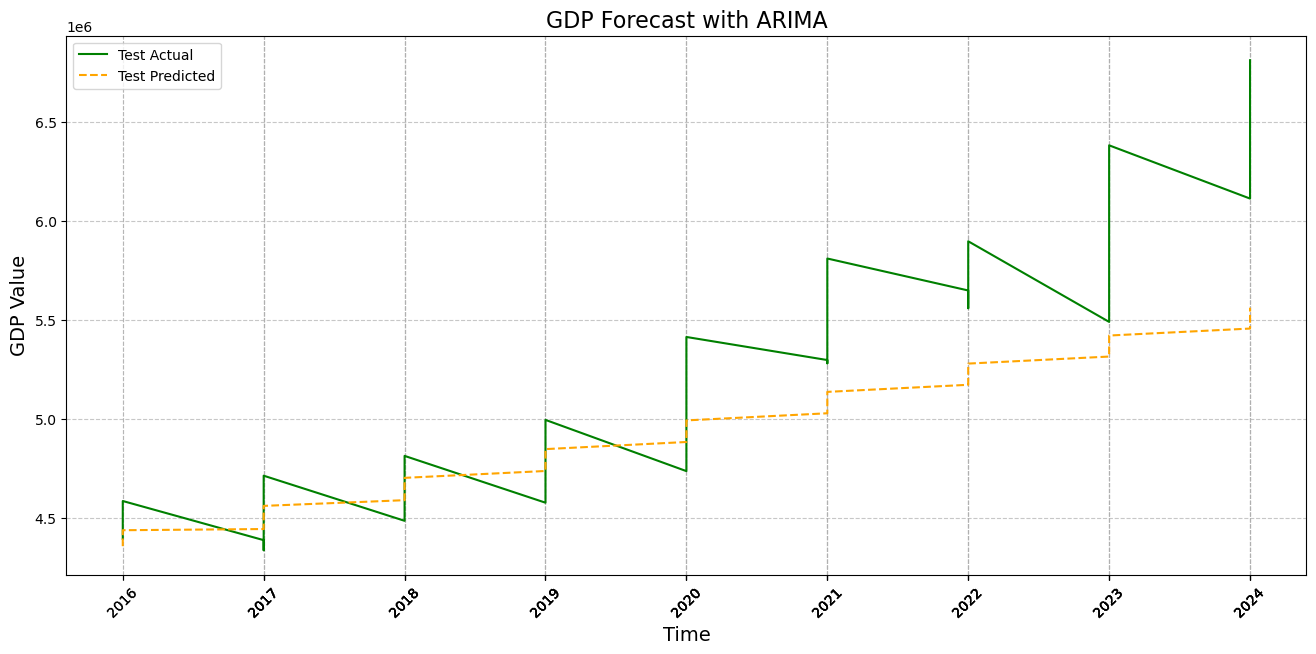

In [45]:
plot_gdp_forecast(y_df['年份'],'ARIMA',test_df,test_pred)

In [28]:
import pickle


with open(os.path.join(base_path, os.getenv("ARIMA")), 'wb') as f:
    pickle.dump(model_fit, f)

